# 02 — Preprocessing

This notebook prepares the raw HAR sensor data for machine learning by:
1. Loading all subject data
2. Applying time-series windowing (128 samples, 50% overlap)
3. Handling potential missing values
4. Scaling features (StandardScaler vs MinMaxScaler comparison)
5. Splitting by subject (train/test) to prevent data leakage
6. Saving processed datasets

---

## 2.1 — Imports and Configuration

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Paths
DATA_DIR = Path('DatasetHAR')
OUTPUT_DIR = Path('processed_data')
OUTPUT_DIR.mkdir(exist_ok=True)

# Windowing parameters
WINDOW_SIZE = 128     # Samples per window (~2.5 seconds at 50 Hz)
OVERLAP = 0.5         # 50 % overlap
STEP = int(WINDOW_SIZE * (1 - OVERLAP))  # 64

# Subject split (67 total: 1-50 train, 51-67 test)
TRAIN_SUBJECTS = list(range(1, 51))
TEST_SUBJECTS = list(range(51, 68))

# Activity label mapping
ACTIVITY_MAP = {
    0: 'Standing', 1: 'Walking', 2: 'Sitting',
    3: 'Lying Down', 4: 'Going Upstairs', 5: 'Going Downstairs'
}

# Plot style
sns.set_theme(style='whitegrid', palette='deep', font_scale=1.1)

print('Configuration:')
print(f'  Window size : {WINDOW_SIZE} samples')
print(f'  Step size   : {STEP} samples')
print(f'  Train subj  : {len(TRAIN_SUBJECTS)} ({TRAIN_SUBJECTS[0]}-{TRAIN_SUBJECTS[-1]})')
print(f'  Test subj   : {len(TEST_SUBJECTS)} ({TEST_SUBJECTS[0]}-{TEST_SUBJECTS[-1]})')

Configuration:
  Window size : 128 samples
  Step size   : 64 samples
  Train subj  : 50 (1-50)
  Test subj   : 17 (51-67)


## 2.2 — Load All Subject Data

We load data from **all 67 subjects** and tag each row with its subject ID.
This enables a subject-wise train/test split that prevents data leakage
(no samples from the same subject appear in both splits).

In [2]:
csv_files = sorted(DATA_DIR.glob('*.csv'),
                   key=lambda f: int(''.join(filter(str.isdigit, f.stem.split('Subject')[1].split('_')[0]))))

all_dfs = []
for f in csv_files:
    subj_id = int(''.join(filter(str.isdigit, f.stem.split('Subject')[1].split('_')[0])))
    df_subj = pd.read_csv(f)
    df_subj['subject'] = subj_id
    all_dfs.append(df_subj)
    if subj_id % 20 == 0:
        print(f'  Loaded subject {subj_id}...')

df_all = pd.concat(all_dfs, ignore_index=True)
print(f'\n✅ Loaded all data: {df_all.shape[0]:,} rows × {df_all.shape[1]} columns')
print(f'   Subjects: {df_all["subject"].nunique()}')

  Loaded subject 20...
  Loaded subject 40...
  Loaded subject 60...

✅ Loaded all data: 7,078,657 rows × 32 columns
   Subjects: 67


## 2.3 — Handle Missing Values

While exploration showed no missing values, we implement robust imputation as a
defensive measure. We compare three imputation strategies.

In [3]:
sensor_cols = [c for c in df_all.columns if c not in ['label', 'subject']]
missing_count = df_all[sensor_cols].isnull().sum().sum()
print(f'Total missing values in sensor columns: {missing_count}')

if missing_count > 0:
    print('\nApplying imputation strategies...')
    
    # Strategy 1: Mean imputation
    df_mean = df_all.copy()
    df_mean[sensor_cols] = df_mean[sensor_cols].fillna(df_mean[sensor_cols].mean())
    
    # Strategy 2: Median imputation
    df_median = df_all.copy()
    df_median[sensor_cols] = df_median[sensor_cols].fillna(df_median[sensor_cols].median())
    
    # Strategy 3: Interpolation (best for time-series)
    df_interp = df_all.copy()
    for subj in df_interp['subject'].unique():
        mask = df_interp['subject'] == subj
        df_interp.loc[mask, sensor_cols] = (
            df_interp.loc[mask, sensor_cols]
            .interpolate(method='linear', limit_direction='both')
        )
    
    # Use interpolation (best for time-series continuity)
    df_all = df_interp
    print('✅ Applied linear interpolation (best for time-series data).')
else:
    print('✅ No missing values — no imputation needed.')

Total missing values in sensor columns: 0
✅ No missing values — no imputation needed.


## 2.4 — Time-Series Windowing

Raw time-series samples are segmented into fixed-length windows. Each window
becomes one input example for our ML models. We use:
- **Window size**: 128 samples (≈2.5 s at 50 Hz)
- **Overlap**: 50% → step size = 64 samples
- **Label**: most frequent (mode) label within each window

This approach captures temporal patterns while keeping examples independent.

In [4]:
def create_windows(df, sensor_cols, window_size, step):
    """
    Segment time-series data into overlapping windows.
    
    Returns:
        X_windows: np.ndarray of shape (n_windows, window_size, n_features)
        y_windows: np.ndarray of shape (n_windows,) — mode label per window
        subjects:  np.ndarray of shape (n_windows,) — subject ID per window
    """
    X_windows, y_windows, subj_windows = [], [], []
    
    for subj_id in sorted(df['subject'].unique()):
        subj_data = df[df['subject'] == subj_id].reset_index(drop=True)
        values = subj_data[sensor_cols].values
        labels = subj_data['label'].values
        
        for start in range(0, len(values) - window_size + 1, step):
            end = start + window_size
            window = values[start:end]
            window_labels = labels[start:end]
            
            # Use mode label for the window
            label_mode = int(stats.mode(window_labels, keepdims=False).mode)
            
            X_windows.append(window)
            y_windows.append(label_mode)
            subj_windows.append(subj_id)
    
    return (np.array(X_windows, dtype=np.float32),
            np.array(y_windows, dtype=np.int64),
            np.array(subj_windows, dtype=np.int64))

print('Creating windows...  (this may take a few minutes)')
X_all, y_all, subj_all = create_windows(df_all, sensor_cols, WINDOW_SIZE, STEP)
print(f'\n✅ Windowing complete:')
print(f'   X shape : {X_all.shape}  →  (n_windows, window_size, n_features)')
print(f'   y shape : {y_all.shape}')
print(f'   Subjects: {len(np.unique(subj_all))}')

Creating windows...  (this may take a few minutes)

✅ Windowing complete:
   X shape : (110505, 128, 30)  →  (n_windows, window_size, n_features)
   y shape : (110505,)
   Subjects: 67


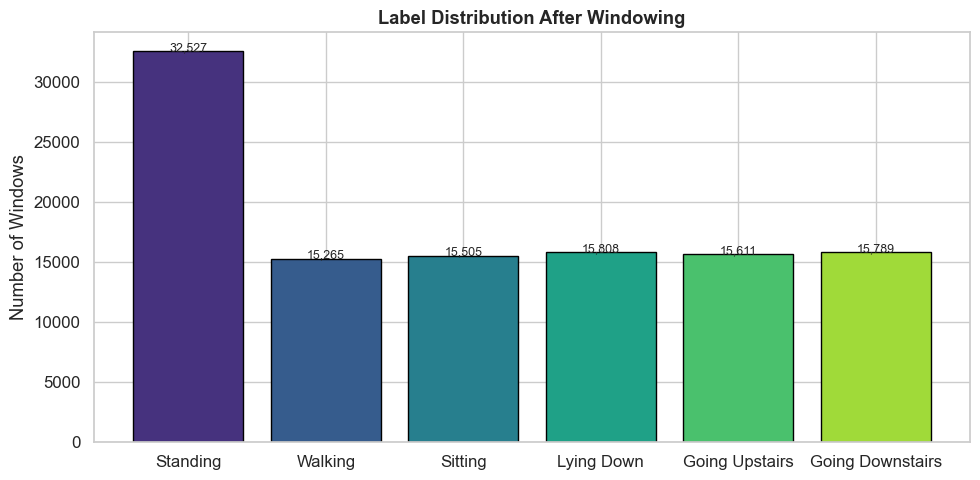

In [5]:
# Visualize label distribution after windowing
unique_labels, counts = np.unique(y_all, return_counts=True)
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar([ACTIVITY_MAP.get(l, str(l)) for l in unique_labels], counts,
              color=sns.color_palette('viridis', len(unique_labels)), edgecolor='black')
ax.set_title('Label Distribution After Windowing', fontweight='bold')
ax.set_ylabel('Number of Windows')
for bar, cnt in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
            f'{cnt:,}', ha='center', fontsize=9)
plt.tight_layout()
plt.show()

## 2.5 — Train / Test Split (Subject-Wise)

We split by **subject** rather than randomly to avoid data leakage. Windows from
the same subject's recording are highly correlated, so mixing subjects between
train and test would inflate evaluation metrics.

- **Train**: Subjects 1–50 (75%)
- **Test**: Subjects 51–67 (25%)

In [6]:
train_mask = np.isin(subj_all, TRAIN_SUBJECTS)
test_mask = np.isin(subj_all, TEST_SUBJECTS)

X_train_raw, y_train = X_all[train_mask], y_all[train_mask]
X_test_raw,  y_test  = X_all[test_mask],  y_all[test_mask]

print(f'Train set: {X_train_raw.shape[0]:,} windows from {np.sum(np.isin(np.unique(subj_all), TRAIN_SUBJECTS))} subjects')
print(f'Test  set: {X_test_raw.shape[0]:,} windows from {np.sum(np.isin(np.unique(subj_all), TEST_SUBJECTS))} subjects')
print(f'\nTrain labels: {dict(zip(*np.unique(y_train, return_counts=True)))}')
print(f'Test  labels: {dict(zip(*np.unique(y_test, return_counts=True)))}')

Train set: 81,935 windows from 50 subjects
Test  set: 28,570 windows from 17 subjects

Train labels: {np.int64(0): np.int64(23953), np.int64(1): np.int64(11356), np.int64(2): np.int64(11511), np.int64(3): np.int64(11767), np.int64(4): np.int64(11638), np.int64(5): np.int64(11710)}
Test  labels: {np.int64(0): np.int64(8574), np.int64(1): np.int64(3909), np.int64(2): np.int64(3994), np.int64(3): np.int64(4041), np.int64(4): np.int64(3973), np.int64(5): np.int64(4079)}


## 2.6 — Feature Scaling

We compare two common scalers and discuss trade-offs:
- **StandardScaler**: Centers to mean=0, std=1 → best for SVM, Logistic Regression, PCA
- **MinMaxScaler**: Scales to [0, 1] → best for neural networks, distance-based algorithms

We fit scalers **only on training data** and apply to test data to prevent data leakage.

In [7]:
def scale_windows(X_train, X_test, scaler):
    """
    Scale windowed data. Reshapes (n, window, features) → (n*window, features),
    fits scaler on train, transforms both, then reshapes back.
    """
    n_train, w, f = X_train.shape
    n_test = X_test.shape[0]
    
    X_train_flat = X_train.reshape(-1, f)
    X_test_flat  = X_test.reshape(-1, f)
    
    scaler.fit(X_train_flat)
    X_train_scaled = scaler.transform(X_train_flat).reshape(n_train, w, f)
    X_test_scaled  = scaler.transform(X_test_flat).reshape(n_test, w, f)
    
    return X_train_scaled.astype(np.float32), X_test_scaled.astype(np.float32)

# StandardScaler (primary)
scaler_std = StandardScaler()
X_train_std, X_test_std = scale_windows(X_train_raw, X_test_raw, scaler_std)

# MinMaxScaler (alternative)
scaler_mm = MinMaxScaler()
X_train_mm, X_test_mm = scale_windows(X_train_raw, X_test_raw, scaler_mm)

print('Scaling complete.')
print(f'  StandardScaler — train range: [{X_train_std.min():.2f}, {X_train_std.max():.2f}]')
print(f'  MinMaxScaler   — train range: [{X_train_mm.min():.2f}, {X_train_mm.max():.2f}]')

Scaling complete.
  StandardScaler — train range: [-82.42, 81.67]
  MinMaxScaler   — train range: [0.00, 1.00]


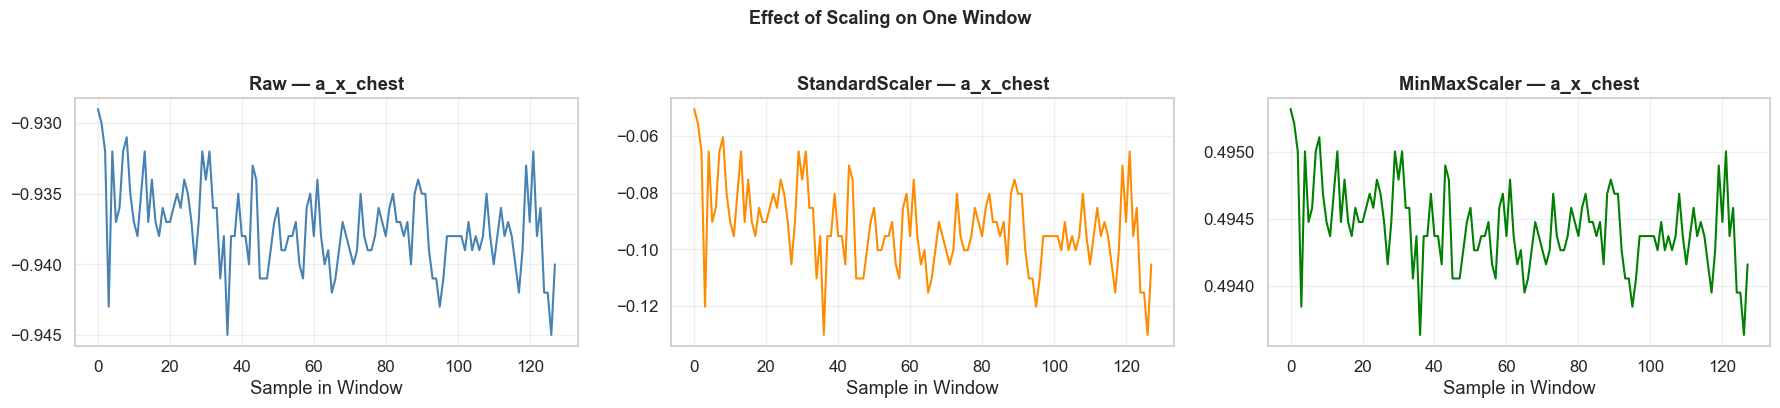

In [8]:
# Visualize scaling effect on one feature
feat_idx = 12  # a_x_chest
feat_name = sensor_cols[feat_idx]

fig, axes = plt.subplots(1, 3, figsize=(18, 4))
sample_win = X_train_raw[0, :, feat_idx]

axes[0].plot(sample_win, color='steelblue')
axes[0].set_title(f'Raw — {feat_name}', fontweight='bold')

axes[1].plot(X_train_std[0, :, feat_idx], color='darkorange')
axes[1].set_title(f'StandardScaler — {feat_name}', fontweight='bold')

axes[2].plot(X_train_mm[0, :, feat_idx], color='green')
axes[2].set_title(f'MinMaxScaler — {feat_name}', fontweight='bold')

for ax in axes:
    ax.set_xlabel('Sample in Window')
    ax.grid(True, alpha=0.3)

plt.suptitle('Effect of Scaling on One Window', fontweight='bold', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

**Scaling decision:** We will use **StandardScaler** as the primary scaler throughout
the project because:
- It preserves the shape of the distribution
- It works well with PCA, SVM, and logistic regression
- Neural networks also perform well with standardized data

We save both scaled versions for flexibility.

## 2.7 — Save Processed Data

We save the windowed, split, and scaled data as NumPy arrays for use in
subsequent notebooks. This ensures reproducibility.

In [9]:
# Save windowed data (StandardScaler)
np.save(OUTPUT_DIR / 'X_train.npy', X_train_std)
np.save(OUTPUT_DIR / 'X_test.npy', X_test_std)
np.save(OUTPUT_DIR / 'y_train.npy', y_train)
np.save(OUTPUT_DIR / 'y_test.npy', y_test)

# Save raw (unscaled) windows as well
np.save(OUTPUT_DIR / 'X_train_raw.npy', X_train_raw)
np.save(OUTPUT_DIR / 'X_test_raw.npy', X_test_raw)

# Save MinMaxScaler version
np.save(OUTPUT_DIR / 'X_train_minmax.npy', X_train_mm)
np.save(OUTPUT_DIR / 'X_test_minmax.npy', X_test_mm)

# Save metadata
import json
metadata = {
    'window_size': WINDOW_SIZE,
    'overlap': OVERLAP,
    'step': STEP,
    'sensor_columns': sensor_cols,
    'n_features': len(sensor_cols),
    'train_subjects': TRAIN_SUBJECTS,
    'test_subjects': TEST_SUBJECTS,
    'activity_map': ACTIVITY_MAP,
    'train_shape': list(X_train_std.shape),
    'test_shape': list(X_test_std.shape),
    'random_state': RANDOM_STATE
}
with open(OUTPUT_DIR / 'metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f'✅ All processed data saved to {OUTPUT_DIR}/')
for p in sorted(OUTPUT_DIR.glob('*')):
    size_mb = p.stat().st_size / 1e6
    print(f'   {p.name:30s}  {size_mb:8.1f} MB')

✅ All processed data saved to processed_data/
   metadata.json                        0.0 MB
   X_test.npy                         438.8 MB
   X_test_minmax.npy                  438.8 MB
   X_test_raw.npy                     438.8 MB
   X_train.npy                       1258.5 MB
   X_train_minmax.npy                1258.5 MB
   X_train_raw.npy                   1258.5 MB
   y_test.npy                           0.2 MB
   y_train.npy                          0.7 MB


## 2.8 — Summary

| Step | Details |
|------|---------|
| **Data Loading** | All 67 subjects loaded, tagged with subject ID |
| **Missing Values** | No missing values; defensive interpolation pipeline in place |
| **Windowing** | 128 samples, 50% overlap → thousands of windows per subject |
| **Train/Test Split** | Subject-wise: 1–50 train, 51–67 test (no leakage) |
| **Scaling** | StandardScaler (primary) and MinMaxScaler (alternative) — fit on train only |
| **Saved Files** | `processed_data/` contains all arrays + metadata |

**Next:** Feature engineering in `03_Feature_Engineering.ipynb`.